In [2]:
!pip install yfinance pandas numpy matplotlib

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 949.2/949.2 kB 36.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 63.7 MB/s eta 0:00:00
  Created wheel for multitasking: filename=multitasking-0.0.12-py3-none-any.whl size=15636 sha256=d35161c8edfe7a4606c9eebb344c1eb00883f773f635ebb4a7fc84296d4a0c84
  Stored in directory: /home/codespace/.cache/pip/wheels/cc/bd/6f/664d62c99327abeef7d86489e6631cbf45b56fbf7ef1d6ef00
  Created wheel for peewee: filename=peewee-3.18.2-cp312-cp312-linux_x86_64.whl size=1049309 sha256=e188d4cf303a3fda7b270546b41f70352e4966376a4f064d8f1e8d89d2833fb4
  Stored in directory: /home/codespace/.cache/pip/wheels/d1/df/a9/0202b051c65b11c992dd6db9f2babdd2c44ec7d35d511be5d3
Successful

In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
from datetime import datetime

def get_annualized_volatility(price_series, periods_per_year=252):
    """
    Рассчитывает годовую волатильность на основе лог-доходностей.
    """
    log_returns = np.log(price_series / price_series.shift(1)).dropna()
    daily_vol = log_returns.std()
    annualized_vol = daily_vol * np.sqrt(periods_per_year)
    return annualized_vol

def get_risk_free_rate(date1):
    """
    Получает безрисковую ставку (IRX — 13-недельный T-Bill) на дату date1.
    Возвращает в долях (например, 0.051 = 5.1%)
    """
    try:
        irx = yf.download('^IRX', start=date1, end=pd.to_datetime(date1) + pd.Timedelta(days=1), auto_adjust=False)['Close']
        rate = float(irx.iloc[0])  # IRX в процентах
        return rate/100
    except Exception:
        return None

def generate_strikes(price, deltas=[-0.10, -0.05, 0.0, 0.05, 0.10]): 
    """
    Генерирует список потенциальных страйков на основе цены. Позднее можно вбить любые другие
    """
    return [round(price * (1 + d), 2) for d in deltas]

def get_close_prices_div_yield_sigma_rf_strikes(tickers, date1, date2):
    """
    Возвращает DataFrame с:
    - ценами закрытия на две даты
    - дивидендной доходностью
    - годовой волатильностью
    - безрисковой ставкой
    - потенциальными страйками (±10%)
    """
    # Загружаем данные за год до date1 и до date2
    full_start = (pd.to_datetime(date1) - pd.Timedelta(days=365)).strftime('%Y-%m-%d')
    full_end = (pd.to_datetime(date2) + pd.Timedelta(days=1)).strftime('%Y-%m-%d')

    price_data = yf.download(tickers, start=full_start, end=full_end, auto_adjust=False)['Close']
    if isinstance(price_data, pd.Series):
        price_data = price_data.to_frame(name=tickers[0])

    prices_selected = price_data.loc[[date1, date2]].T

    div_yields = []
    sigmas = []
    strike_sets = []

    for ticker in tickers:
        ticker_obj = yf.Ticker(ticker)

        # Дивиденды за период
        divs = ticker_obj.dividends
        divs_in_period = divs[(divs.index >= date1) & (divs.index <= date2)]
        total_divs = divs_in_period.sum()

        try:
            price_start = prices_selected.loc[ticker, date1]
            div_yield = total_divs / price_start if price_start else None
            strikes = generate_strikes(price_start)
        except KeyError:
            div_yield = None
            strikes = None


        div_yields.append(div_yield)
        strike_sets.append(strikes)

        # Волатильность (лог-доходности)
        try:
            price_series = price_data[ticker]
            one_year_prices = price_series.loc[
                (price_series.index >= pd.to_datetime(date1) - pd.Timedelta(days=365)) &
                (price_series.index < pd.to_datetime(date1))
            ]
            sigma = get_annualized_volatility(one_year_prices)
        except Exception:
            sigma = None
        sigmas.append(sigma)

    # Безрисковая ставка (одна для всех)
    risk_free = get_risk_free_rate(date1)

    prices_selected['Dividend Yield'] = div_yields
    prices_selected['Annualized Sigma'] = sigmas
    prices_selected['Risk-Free Rate (IRX)'] = risk_free
    prices_selected['Strikes (±10%)'] = strike_sets
        # Добавляем Strike-Worst-of opt -10%
    try:
        minus_10_strikes = [s[3] for s in strike_sets if s is not None]
        strike_worst_of = round(np.mean(minus_10_strikes), 2)
    except:
        strike_worst_of = None

    prices_selected['Strike-Worst-of opt который выбрали'] = strike_worst_of

    return prices_selected

# === Пример использования ===
# tickers = input("Введите список тикеров через запятую с пробелом").split(", ")
# date1 = str(input("Введите дату T0 в формате год полностью-мес-число"))
# date2 = str(input("Введите дату экспирации в формате год полностью-мес-число"))
tickers = ['MSFT','META']
date1 = '2023-09-01'
date2 = '2024-03-01'
df = get_close_prices_div_yield_sigma_rf_strikes(tickers, date1, date2)
print(df)

[*********************100%***********************]  2 of 2 completed
[*********************100%***********************]  1 of 1 completed

Date    2023-09-01 00:00:00  2024-03-01 00:00:00  Dividend Yield  \
Ticker                                                             
META             296.380005           502.299988        0.004564   
MSFT             328.660004           415.500000        0.001687   

Date    Annualized Sigma  Risk-Free Rate (IRX)  \
Ticker                                           
META            0.312143               0.05268   
MSFT            0.540745               0.05268   

Date                              Strikes (±10%)  \
Ticker                                             
META    [295.79, 312.23, 328.66, 345.09, 361.53]   
MSFT     [266.74, 281.56, 296.38, 311.2, 326.02]   

Date    Strike-Worst-of opt который выбрали  
Ticker                                       
META                                 328.14  
MSFT                                 328.14  



/tmp/ipykernel_652/3430619200.py:22: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  rate = float(irx.iloc[0])  # IRX в процентах


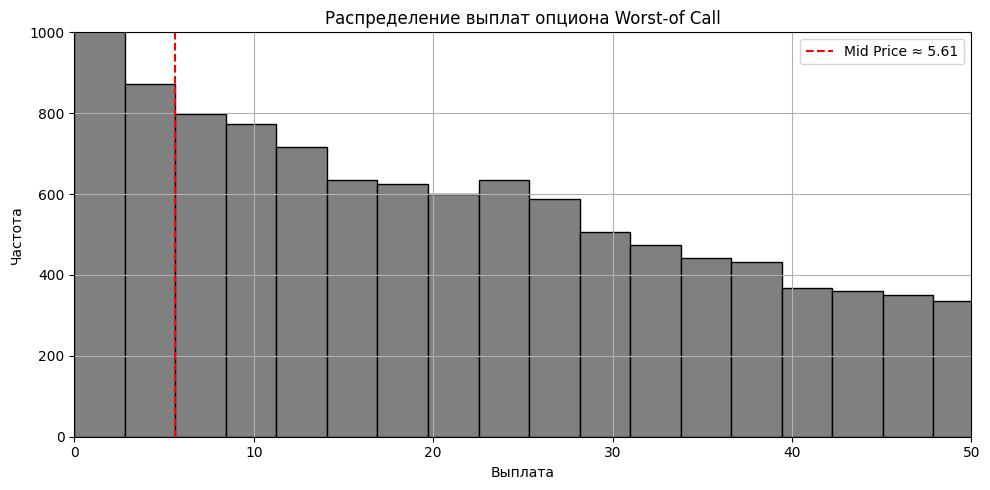

{'mid_price': 5.61, 'bid_price': 5.06, 'offer_price': 5.95}


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

def run_worst_of_option_from_dataframe(df, date1, maturity=0.5, vol_spread=0.04, show_plot=True, n_paths=100_000, seed=42):
    """
    Использует данные из датафрейма для оценки worst-of call опциона
    """
    date1_col = pd.to_datetime(date1)

    if date1_col not in df.columns:
        raise KeyError(f"Колонка с датой {date1} (преобразованной в Timestamp) отсутствует в DataFrame.\nНаличие колонок: {list(df.columns)}")

    spot_prices = df[date1_col].tolist()
    vols = df['Annualized Sigma'].tolist()
    div_yields = df['Dividend Yield'].fillna(0).tolist()
    r = df['Risk-Free Rate (IRX)'].iloc[0]
    forwards = [r - q for q in div_yields]
    vol_spreads = [vol_spread] * len(spot_prices)
    strike = df['Strike-Worst-of opt который выбрали'].iloc[0]

    np.random.seed(seed)
    n_assets = len(spot_prices)

    def simulate_terminal_prices(spot, r, sigma):
        z = np.random.randn(n_paths)
        return spot * np.exp((r - 0.5 * sigma**2) * maturity + sigma * np.sqrt(maturity) * z)

    def price_option(vols_input, return_payoffs=False):
        simulated = np.array([
            simulate_terminal_prices(spot_prices[i], forwards[i], vols_input[i])
            for i in range(n_assets)
        ])
        worst_prices = np.min(simulated, axis=0)
        payoffs = np.maximum(worst_prices - strike, 0)
        discounted=np.exp(-r*maturity)*payoffs
        if return_payoffs:
            return np.mean(discounted), payoffs
        return np.mean(discounted)

    # Mid
    mid_price, mid_payoffs = price_option(vols, return_payoffs=True)
    # Bid/Offer
    bid_vols = [v - s / 2 for v, s in zip(vols, vol_spreads)]
    offer_vols = [v + s / 2 for v, s in zip(vols, vol_spreads)]
    bid_price = price_option(bid_vols)
    offer_price = price_option(offer_vols)

    if show_plot:
        plt.figure(figsize=(10, 5))
        plt.hist(mid_payoffs, bins=100, color='gray', edgecolor='black')
        plt.axvline(mid_price, color='red', linestyle='--', label=f'Mid Price ≈ {mid_price:.2f}')
        plt.title("Распределение выплат опциона Worst-of Call")
        plt.xlabel("Выплата")
        plt.ylabel("Частота")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        # plt.xlim(0, np.percentile(mid_payoffs, 99) * 1.1)  # масштаб X: от 0 до 110% перцентиля 99
        # plt.ylim(0, plt.ylim()[1] * 1.1)     
        plt.xlim(0, 50)  # если ожидаешь выплату до $50
        plt.ylim(0, 1000)  # если частота высокая
        plt.savefig("output_plot.png")
        plt.show()

    return {
        "mid_price": float(round(mid_price,2)),
        "bid_price": float(round(bid_price,2)),
        "offer_price": float(round(offer_price,2))
    }
result = run_worst_of_option_from_dataframe(df, date1=date1, maturity=0.5)
print(result)
